In [1]:
# Para cargar lo necesario
import pickle

import sys
import os

# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Ahora puedes importar
import customFunctions as cf

#from qiskit.circuit.library import TwoLocal
#from qiskit.circuit import QuantumCircuit

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import QuantumCircuit

def crear_ansatz_nlocal(num_qubits: int, reps: int = 1) -> tuple[QuantumCircuit, int]:
    """
    Crea un ansatz N-local (TwoLocal) con un número dado de qubits y repeticiones.
    Devuelve el circuito y el número de parámetros libres.

    Args:
        num_qubits (int): Número de qubits del circuito.
        reps (int): Número de repeticiones (capas) del ansatz.

    Returns:
        tuple: (QuantumCircuit, número de parámetros del circuito)
    """
    ansatz = TwoLocal(num_qubits,
                      rotation_blocks='ry',
                      entanglement_blocks='cz',
                      entanglement='linear',
                      reps=reps,
                      insert_barriers=True)
    
    return ansatz, ansatz.num_parameters


In [3]:
# 0.719

with open("hamiltonian0.719.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print(hamiltonian)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80499838+0.j,  0.17472226+0.j, -0.23347838+0.j,  0.12184887+0.j,
  0.17472226+0.j,  0.16970294+0.j, -0.23347838+0.j,  0.16685625+0.j,
  0.04500738+0.j,  0.04500738+0.j,  0.04500738+0.j,  0.04500738+0.j,
  0.16685625+0.j,  0.17539742+0.j,  0.12184887+0.j])


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@     @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@  @@@@@+ @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ @@@@@@@@@ *@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ @@@@@@@@@@@ @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ @@@@@@@@@@@@@ @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@  @@@@@@@@@@@@@  @@@@@=   @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@:        @@@@@@@ @@@@@@@@@@@@@@@ @@@@  .    @    @@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@ @@@@@@@@@@@@@     @@@@@@@@@@@@@@@    @      =@@@@@@ *@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@  @@@@@@@@@@@@@@@@  -   #@@@@@@    @ @@@@@   @@@@@@@@@ @@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@  @@@@@@@@@@@@@@@@ @@@@@@     @@@@@@ .@@@@@@@@@@@@@@@  @@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

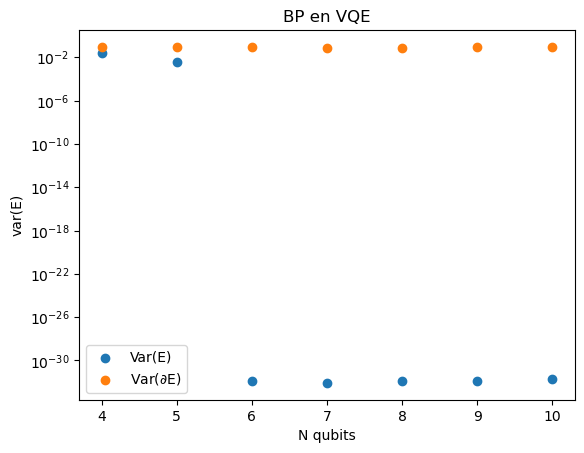

In [4]:
data = cf.variance_vs_nQubits(crear_ansatz_nlocal, 4, 10, hamiltonian, 0, 100)